# Predict using minimal data to show true demand

prepare a model that will use only arrival rates and aspirational targes for ED

Inputs
- A series of times in the day at which we want to make these predictions is set 
- A series of dates on which we want to make these predictions
- A time window after the prediction time, within which we are interested in predicting a number of patients (eg 8 hours)

## Set up the notebook environment

In [1]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [2]:
from pathlib import Path
import sys
import json
import pandas as pd

PROJECT_ROOT = Path().home() 
USER_ROOT = Path().home() / 'Repos' 



model_file_path = USER_ROOT / 'patientflow' / 'trained-models'
# model_file_path.mkdir(parents=True, exist_ok=True)
data_path = USER_ROOT / 'ed-predictor' / 'data-raw'
media_file_path = USER_ROOT / 'patientflow' / 'notebooks' / 'experiments' / 'img'
# media_file_path.mkdir(parents=True, exist_ok=True)

In [3]:
data_path= USER_ROOT / 'patientflow' / 'data-public'

In [4]:
import numpy as np
seed_path = USER_ROOT / 'seed' 
    # Read the seed from a saved file
with open(seed_path, 'r') as file:
    seed = int(file.read().strip())
# Set the seed for numpy
np.random.seed(seed=seed)
n = np.random.randint(1, 10*52)  


## Load parameters

These are set in config.json. You can change these for your own purposes. But the times of day will need to match those in the provided dataset if you want to run this notebook successfully.

In [5]:
uclh = False

In [6]:
from patientflow.load import load_config_file

if uclh:
    config_path = Path(USER_ROOT / 'patientflow' / 'config-uclh.yaml')
else:
    config_path = Path(USER_ROOT / 'patientflow' / 'config.yaml')

params = load_config_file(config_path)

prediction_times = params[0]
start_training_set, start_validation_set, start_test_set, end_test_set = params[1:5]

x1, y1, x2, y2 = params[5:9]

# set y1 to .8
y1 = .8

## Load data

In [9]:
import pandas as pd
from patientflow.load import set_file_locations

if uclh:

    visits_path, visits_csv_path, yta_path, yta_csv_path = set_file_locations(uclh, data_path, config_path)
else:
    visits_csv_path, yta_csv_path = set_file_locations(uclh, data_path)

inpatient_arrivals = pd.read_csv(yta_csv_path)

inpatient_arrivals['arrival_datetime'] = pd.to_datetime(inpatient_arrivals['arrival_datetime'], utc = True)

weekdays_yta = inpatient_arrivals[inpatient_arrivals['arrival_datetime'].dt.weekday < 5] 

inpatient_arrivals.set_index('arrival_datetime', inplace=True)
weekdays_yta.set_index('arrival_datetime', inplace=True)


## Separate into training, validation and test sets

As part of preparing the data, each visit has already been allocated into one of three sets - training, vaidation and test sets. 

In [10]:
def get_training_set(inpatient_arrivals):


    train_yta = inpatient_arrivals[inpatient_arrivals.training_validation_test == 'train']#.drop(columns='training_validation_test')
    valid_yta = inpatient_arrivals[inpatient_arrivals.training_validation_test == 'valid']#.drop(columns='training_validation_test')
    test_yta = inpatient_arrivals[inpatient_arrivals.training_validation_test == 'test']#.drop(columns='training_validation_test')



    return (train_yta, valid_yta, test_yta)

train_yta, valid_yta, test_yta = get_training_set(weekdays_yta)

In [11]:
isinstance(train_yta.index, pd.DatetimeIndex)

True

## Get arrival rates by hour

Calculating time-varying arrival rates for data provided, which spans 306 unique dates


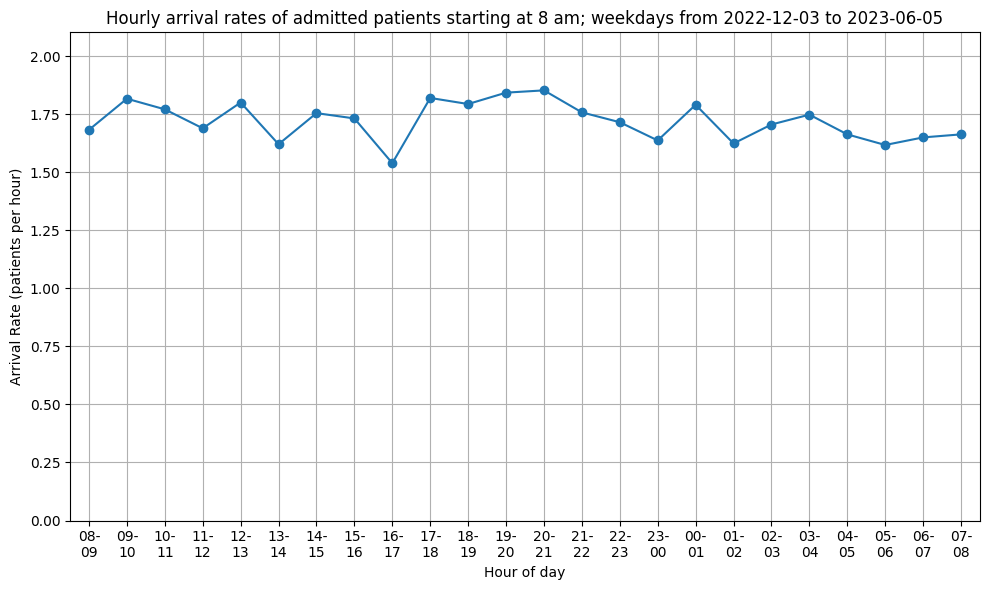

In [91]:
from patientflow.viz.arrival_rates import plot_arrival_rates
from datetime import timedelta
start_plot_index = 8
title = f'Hourly arrival rates of admitted patients starting at {start_plot_index} am; weekdays from {start_training_set - timedelta(days=n*7)} to {start_validation_set - timedelta(days=n*7)}'

plot_arrival_rates(inpatient_arrivals, title, time_interval=60, start_plot_index=start_plot_index, file_prefix = '1_')

Calculating time-varying arrival rates for data provided, which spans 306 unique dates
Calculating time-varying arrival rates for data provided, which spans 306 unique dates


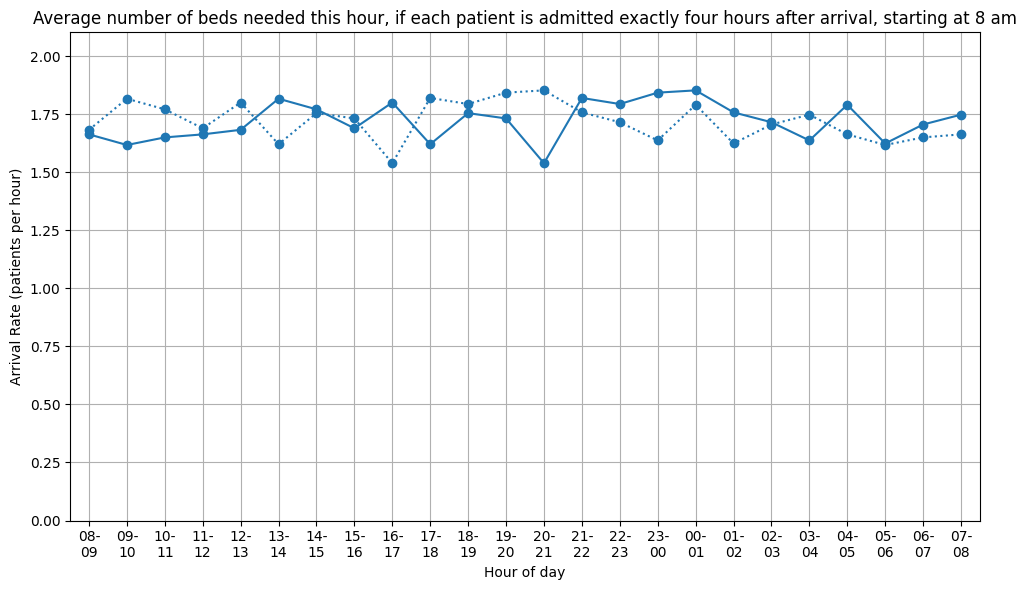

In [92]:
title = 'Average number of beds needed this hour, if each patient is admitted exactly four hours after arrival, starting at 8 am'
plot_arrival_rates(inpatient_arrivals, title, time_interval=60, start_plot_index=start_plot_index, file_prefix = '2_', lagged_by=4)

In [81]:
start_of_influencable_window = 8
end_of_influencable_window = 17

## Plot cumulative arrival rates with or without line

Calculating time-varying arrival rates for data provided, which spans 306 unique dates


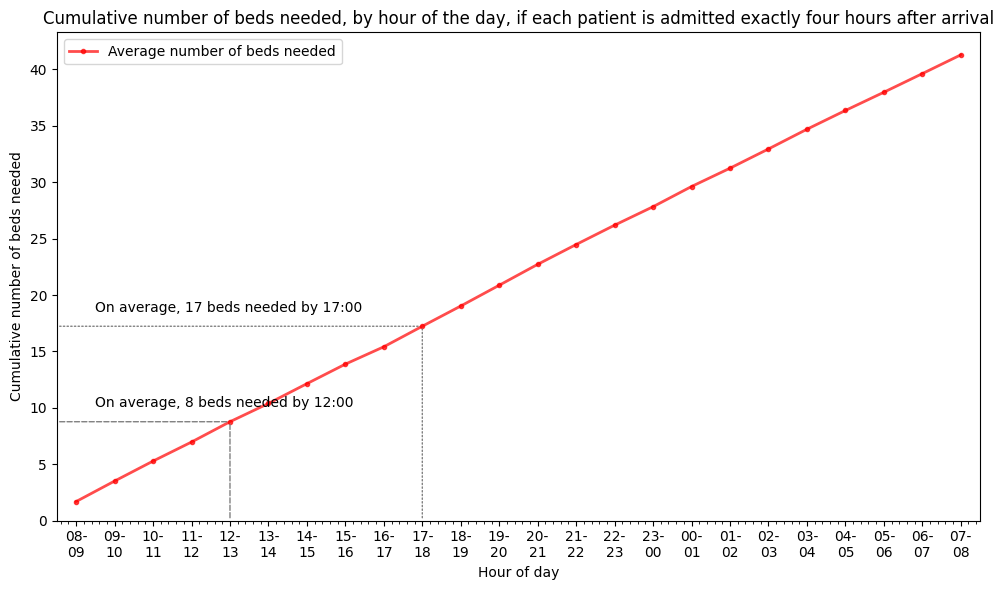

In [85]:
from patientflow.viz.arrival_rates import plot_cumulative_arrival_rates
title = 'Cumulative number of beds needed, by hour of the day, if each patient is admitted exactly four hours after arrival'
plot_cumulative_arrival_rates(inpatient_arrivals, title, start_plot_index = 8, file_prefix = '3_')

Calculating time-varying arrival rates for data provided, which spans 306 unique dates


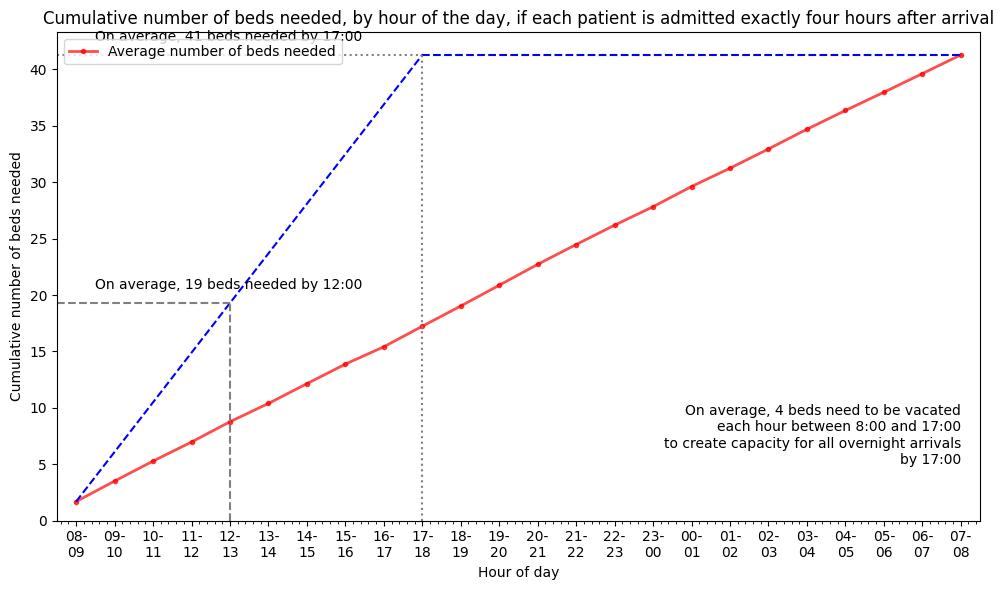

In [86]:
title = 'Cumulative number of beds needed, by hour of the day, if each patient is admitted exactly four hours after arrival'
plot_cumulative_arrival_rates(inpatient_arrivals, title, start_plot_index = 8, 
                              draw_window=(start_of_influencable_window, end_of_influencable_window),
                              file_prefix = '4_')



Calculating time-varying arrival rates for data provided, which spans 306 unique dates


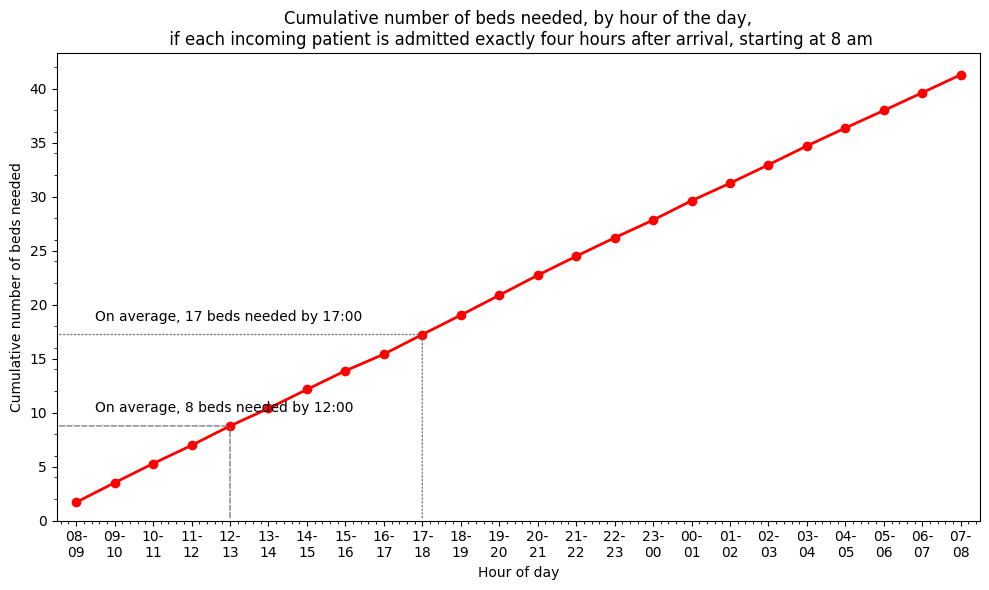

Calculating time-varying arrival rates for data provided, which spans 306 unique dates


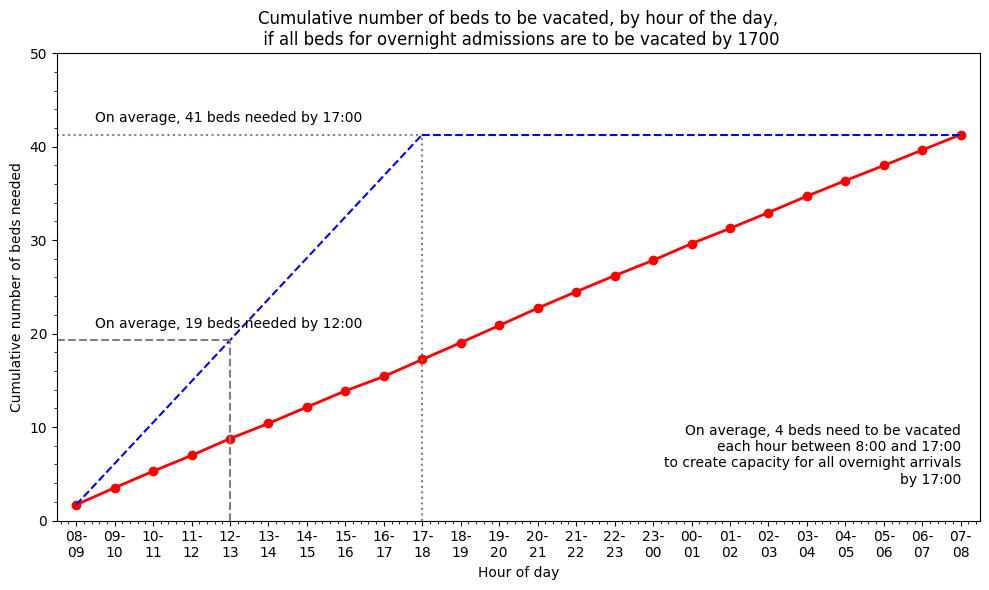

Calculating time-varying arrival rates for data provided, which spans 306 unique dates


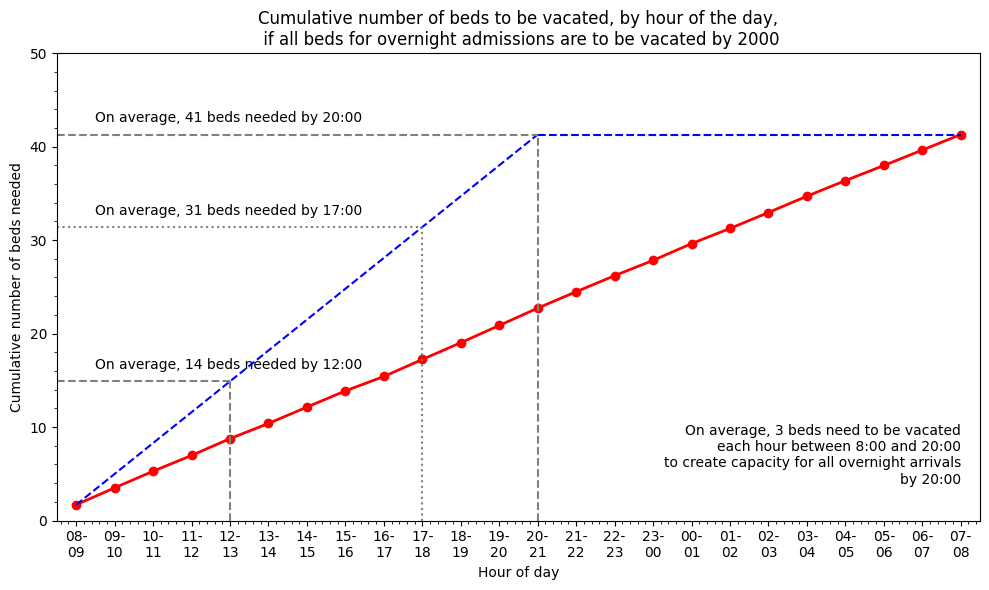

In [17]:
title = 'Cumulative number of beds needed, by hour of the day,\n if each incoming patient is admitted exactly four hours after arrival, starting at 8 am'
plot_cumulative_arrival_rates(inpatient_arrivals, title, start_plot_index = 8, file_prefix = '3_')

end_of_influencable_window = 17
title = f'Cumulative number of beds to be vacated, by hour of the day,\n if all beds for overnight admissions are to be vacated by {end_of_influencable_window}00'
plot_cumulative_arrival_rates(inpatient_arrivals, title, start_plot_index = 8, draw_window = (start_of_influencable_window, end_of_influencable_window), file_prefix = '4_', set_y_lim = 50)

end_of_influencable_window = 20
title = f'Cumulative number of beds to be vacated, by hour of the day,\n if all beds for overnight admissions are to be vacated by {end_of_influencable_window}00'
plot_cumulative_arrival_rates(inpatient_arrivals, title, start_plot_index = 8, draw_window = (start_of_influencable_window, end_of_influencable_window), file_prefix = '4_', set_y_lim = 50, hour_lines = [12,17,20])


## Plot aspirational curve

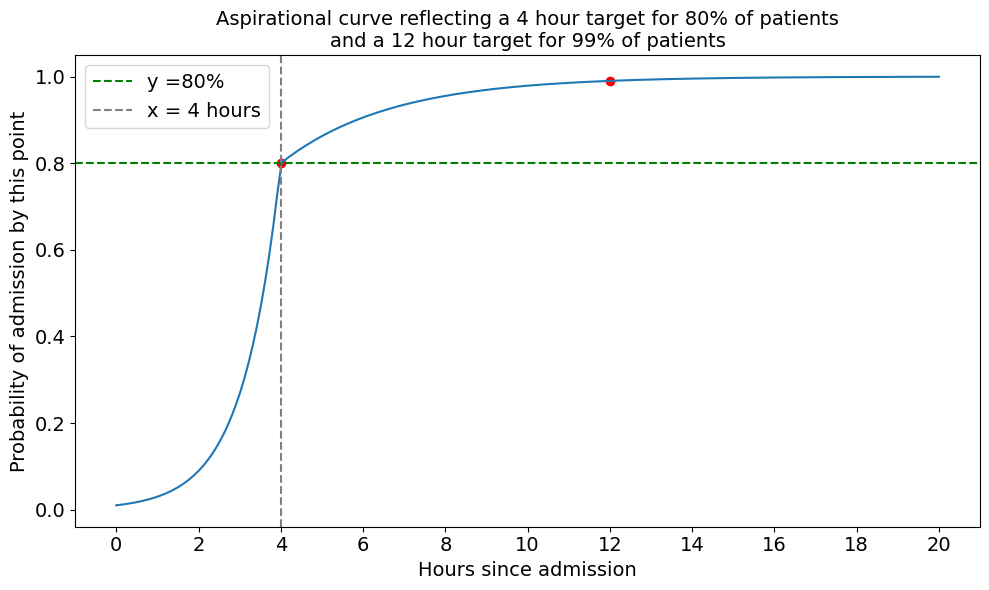

In [23]:
import matplotlib.pyplot as plt
from patientflow.viz.aspirational_curve_plot import plot_curve

figsize = (6,3)
title = 'Aspirational curve reflecting a ' + str(int(x1)) + ' hour target for ' + str(int(y1*100)) + \
        '% of patients\nand a '+ str(int(x2)) + ' hour target for ' + str(int(y2*100)) + '% of patients'

plot_curve(
    title = title,
    x1 = x1,
    y1 = y1,
    x2 = x2,
    y2 = y2,
    figsize = (10,6),
    include_titles=True,
    text_size=14,
    directory_path=media_file_path,
    file_name=title.replace(" ", "_"),
)


## Detailed working

For each hour after arrival, calculate the probability of being admitted in that hour if ED is performing according to targets

In [19]:
max_hours_since_arrival = 12
hours_since_arrival = np.arange(max_hours_since_arrival + 1)

from patientflow.predict.admission_in_prediction_window import get_y_from_aspirational_curve
prob_admission_by_this_hour = []
for i in range(len(hours_since_arrival)):
    prob = get_y_from_aspirational_curve(hours_since_arrival[i], x1, y1, x2, y2)
    prob_admission_by_this_hour.append(prob)
prob_admission_by_this_hour = np.array(prob_admission_by_this_hour)
prob_admission_by_this_hour

prob_admission_within_this_hour = np.diff(prob_admission_by_this_hour)
prob_admission_within_this_hour

array([0.01990698, 0.05953574, 0.1780534 , 0.53250388, 0.0624688 ,
       0.04295704, 0.02953967, 0.02031313, 0.01396845, 0.00960549,
       0.00660527, 0.00454215])

In [ ]:
# or use function 

prob_admission_by_this_hour, prob_admission_within_this_hour= calculate_admission_probabilities(hours_since_arrival, x1, y1, x2, y2)
prob_admission_within_this_hour

array([0.01990698, 0.05953574, 0.1780534 , 0.53250388, 0.0624688 ,
       0.04295704, 0.02953967, 0.02031313, 0.01396845, 0.00960549,
       0.00660527, 0.00454215])

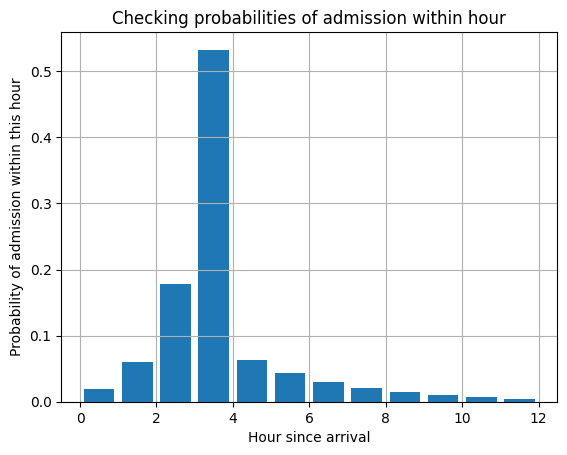

In [43]:
# plot these to check they are what we'd expect
plt.bar(np.arange(len(prob_admission_within_this_hour)) + 0.5, prob_admission_within_this_hour) # shifting bars to the left to portray the probability of admission within the hour
plt.xlabel('Hour since arrival')
plt.ylabel('Probability of admission within this hour')
plt.title('Checking probabilities of admission within hour')
plt.grid()
plt.show()

### Calculate true demand by hour

In [26]:
from patientflow.prepare import calculate_time_varying_arrival_rates
poisson_means_dict = calculate_time_varying_arrival_rates(inpatient_arrivals, time_interval = 60)
poisson_means = np.array(list(poisson_means_dict.values()))

Calculating time-varying arrival rates for data provided, which spans 306 unique dates


In [27]:
# poisson mean at hour zero
poisson_means

array([1.79084967, 1.62418301, 1.70588235, 1.74836601, 1.66339869,
       1.61764706, 1.6503268 , 1.66339869, 1.68300654, 1.81699346,
       1.77124183, 1.68954248, 1.80065359, 1.62091503, 1.75490196,
       1.73202614, 1.53921569, 1.82026144, 1.79411765, 1.84313725,
       1.85294118, 1.75816993, 1.71568627, 1.6372549 ])

At hour zero, we have 0.75 arrivals on average, with a probability of this of being admitted within the hour between midnight and 1 am

In [28]:
# Probability of admission in first hour
prob_admission_within_this_hour

array([0.01990698, 0.05953574, 0.1780534 , 0.53250388, 0.0624688 ,
       0.04295704, 0.02953967, 0.02031313, 0.01396845, 0.00960549,
       0.00660527, 0.00454215])

We can multiply these to get a average number of patients who arrived and were admitted over the hour between midnight and 1 am 

In [29]:
# Average number of patients arriving between 0 and 1 hours, admitted between 0 and 1 if ED hitting targets
poisson_means[0] * prob_admission_within_this_hour[0]

0.03565040079145286

Similarly we can get an average number of patients who arrived between midnight and 1 am and were admitted between 3 am and 4 am

In [30]:
# Average number of patients arriving between 0 and 1 hours, admitted between 3 and 4 hours, if ED hitting targets
# Probability of admission in fourth hour
poisson_means[0] * prob_admission_within_this_hour[3]

0.953634395912315

This code sets up a 2D array called poisson_means_all with dimensions (max_hours_since_arrival, 24, where:

* The first dimension represents the hour since arrival (0 to 11).
* The second dimension holds the Poisson means for arrival rates within each hour after arrival, weighted by the probability of admission within that hour. This has length 24 for each hour in the day
  
Access the Poisson mean for any specific hour of the day, and hour after arrival using poisson_means_all[hour, i].

In [31]:
# # Create an empty array to hold a Poisson distribution for each hour of the day, up to an arbitrary maximum number of arrivals in that hour
from scipy.stats import poisson
max_hours_since_arrival = 10
# # Initialize a 3D array to hold all distributions across all hours



In [32]:
poisson_means_all = np.zeros((max_hours_since_arrival, len(poisson_means)))

for hour_of_day in range(0,24):
    arrival_rate = poisson_means[hour_of_day]
    for elapsed_hour_since_arrival in range(0, max_hours_since_arrival):
        weighted_arrival_rate = arrival_rate*prob_admission_within_this_hour[elapsed_hour_since_arrival]
        poisson_means_all[elapsed_hour_since_arrival][hour_of_day] = weighted_arrival_rate



In [33]:
# # this holds the weighted arrival rates for patients admitted within the first hour of arrival, for each hour of the day
poisson_means_all[0]

array([0.0356504 , 0.03233257, 0.03395896, 0.03480468, 0.03311324,
       0.03220246, 0.03285302, 0.03311324, 0.03350357, 0.03617084,
       0.03526007, 0.03363368, 0.03584557, 0.03226752, 0.03493479,
       0.0344794 , 0.03064113, 0.0362359 , 0.03571546, 0.03669129,
       0.03688645, 0.03499985, 0.03415412, 0.03259279])

In [34]:
# # this holds the weighted arrival rates for patients admitted within the fourth hour of arrival, for each hour of the day
poisson_means_all[3]

array([0.9536344 , 0.86488375, 0.90838897, 0.93101168, 0.88576625,
       0.86140333, 0.87880542, 0.88576625, 0.89620751, 0.96755607,
       0.94319314, 0.89968792, 0.95885502, 0.86314354, 0.9344921 ,
       0.92231064, 0.81963832, 0.96929627, 0.9553746 , 0.98147774,
       0.98669836, 0.93623231, 0.91360959, 0.87184458])

For arrivals in the 23rd hour of the day, here are the arrival rates for each of the following 10 hours

In [35]:
for elapsed_hour_since_arrival in range(0, max_hours_since_arrival):
    print(poisson_means_all[elapsed_hour_since_arrival][23])

0.032592793424302706
0.09747518784725213
0.2915188066933959
0.8718445845840689
0.10227734183741848
0.07033163002186543
0.048363968916943924
0.033257774470347605
0.022869908890645087
0.015726630569725585


So to get all of the admissions at 3 am for patients in that hour and the preceding five hours, we need 

In [36]:
total_admissions = poisson_means_all[0][3] + \
                  poisson_means_all[1][2] + \
                  poisson_means_all[2][1] + \
                  poisson_means_all[3][0] + \
                  poisson_means_all[4][23] + \
                  poisson_means_all[5][22]
total_admissions



1.555169512652657

In [37]:
def calculate_sum(poisson_means_all, elapsed_hour_since_arrival, hour_of_day):
    total_sum = 0
    for i in range(len(elapsed_hour_since_arrival)):
        hour_index = (hour_of_day - elapsed_hour_since_arrival[i]) % 24
        total_sum += poisson_means_all[elapsed_hour_since_arrival[i]][hour_index]
    return total_sum

# # Example usage:
# poisson_means_all = [
#     [0] * 24, [0] * 24, [0] * 24, [0] * 24, [0] * 24, [0] * 24
# ]
# # Populate poisson_means_all with example data
# poisson_means_all[0][3] = 5
# poisson_means_all[1][2] = 10
# poisson_means_all[2][1] = 15
# poisson_means_all[3][0] = 20
# poisson_means_all[4][23] = 25
# poisson_means_all[5][22] = 30

elapsed_hour_since_arrival = range(0, 6)
hour_of_day = 3  # Example current hour of the day

result = calculate_sum(poisson_means_all, elapsed_hour_since_arrival, hour_of_day)
print(result)  # Output should be 105

1.555169512652657


Now let's add a third dimension

In [ ]:
def calculate_sum_of_weighted_arrival_rates(poisson_means_all, elapsed_hour_since_arrival, hour_of_day):
    total_sum = 0
    for i in range(len(elapsed_hour_since_arrival)):
        hour_index = (hour_of_day - elapsed_hour_since_arrival[i]) % 24
        total_sum += poisson_means_all[elapsed_hour_since_arrival[i]][hour_index]
    return total_sum

# Initialize a 3D array to hold all summed poisson means across all hours
poisson_means_sum = np.zeros(len(poisson_means))
elapsed_hour_since_arrival = range(0, max_hours_since_arrival)

for hour_of_day in range(0,24):
    sum_arrival_rates = calculate_sum_of_weighted_arrival_rates(poisson_means_all, elapsed_hour_since_arrival, hour_of_day)
    poisson_means_sum[hour_of_day] = sum_arrival_rates

arrival_rates_spread = poisson_means_sum

### Combining the above in one function 

In [57]:
from patientflow.calculate import get_true_demand_by_hour
arrival_rates_spread_dict = get_true_demand_by_hour(inpatient_arrivals, x1, y1, x2, y2)
arrival_rates_spread_dict

Calculating time-varying arrival rates for data provided, which spans 306 unique dates


{datetime.time(0, 0): 1.6978786680383946,
 datetime.time(1, 0): 1.6646091284769187,
 datetime.time(2, 0): 1.6387906971538178,
 datetime.time(3, 0): 1.6877234491778188,
 datetime.time(4, 0): 1.6180109526549071,
 datetime.time(5, 0): 1.6548882251074535,
 datetime.time(6, 0): 1.6596932654157843,
 datetime.time(7, 0): 1.6113639754522513,
 datetime.time(8, 0): 1.5909254944269537,
 datetime.time(9, 0): 1.6100435259735306,
 datetime.time(10, 0): 1.6255313160131433,
 datetime.time(11, 0): 1.6560003153400655,
 datetime.time(12, 0): 1.717594107632342,
 datetime.time(13, 0): 1.6905284024297724,
 datetime.time(14, 0): 1.6625326923085297,
 datetime.time(15, 0): 1.6950020607774394,
 datetime.time(16, 0): 1.6231482800016637,
 datetime.time(17, 0): 1.6768015336437931,
 datetime.time(18, 0): 1.649420849402095,
 datetime.time(19, 0): 1.5959026023224758,
 datetime.time(20, 0): 1.7320659989449665,
 datetime.time(21, 0): 1.7354460920107235,
 datetime.time(22, 0): 1.7612314470401158,
 datetime.time(23, 0): 

## Plot true demand per hour against arrival rates 

Calculating time-varying arrival rates for data provided, which spans 306 unique dates
Calculating time-varying arrival rates for data provided, which spans 306 unique dates
Calculating time-varying arrival rates for data provided, which spans 306 unique dates


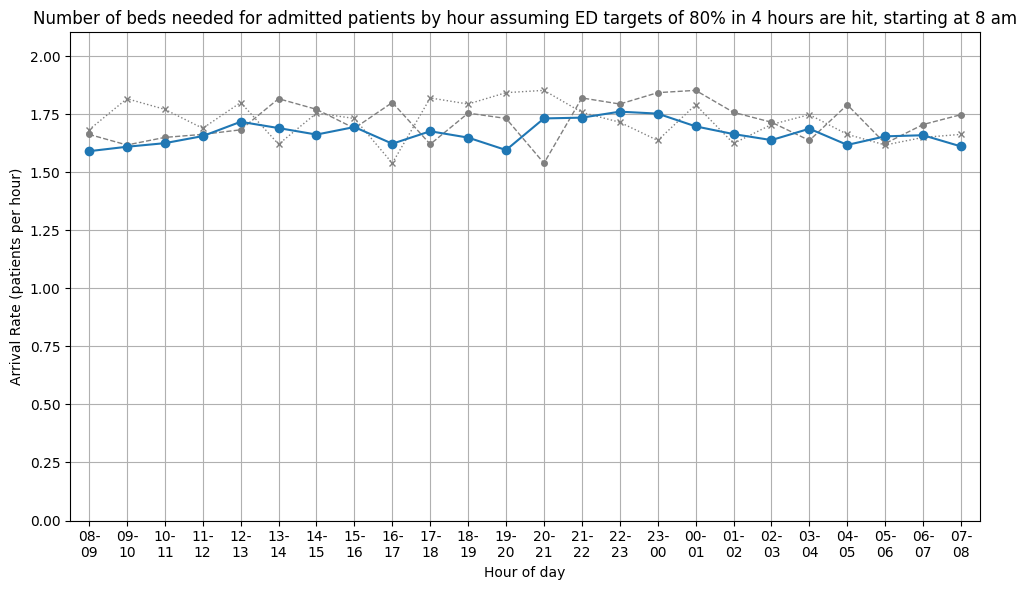

In [98]:

title = f'Number of beds needed for admitted patients by hour assuming ED targets of {int(y1*100)}% in {int(x1)} hours are hit, starting at 8 am'

plot_arrival_rates(inpatient_arrivals, title, start_plot_index = 8, 
                   lagged_by=4, 
                   curve_params=(x1, y1, x2, y2), 
                   file_prefix = '5_')



Calculating time-varying arrival rates for data provided, which spans 306 unique dates


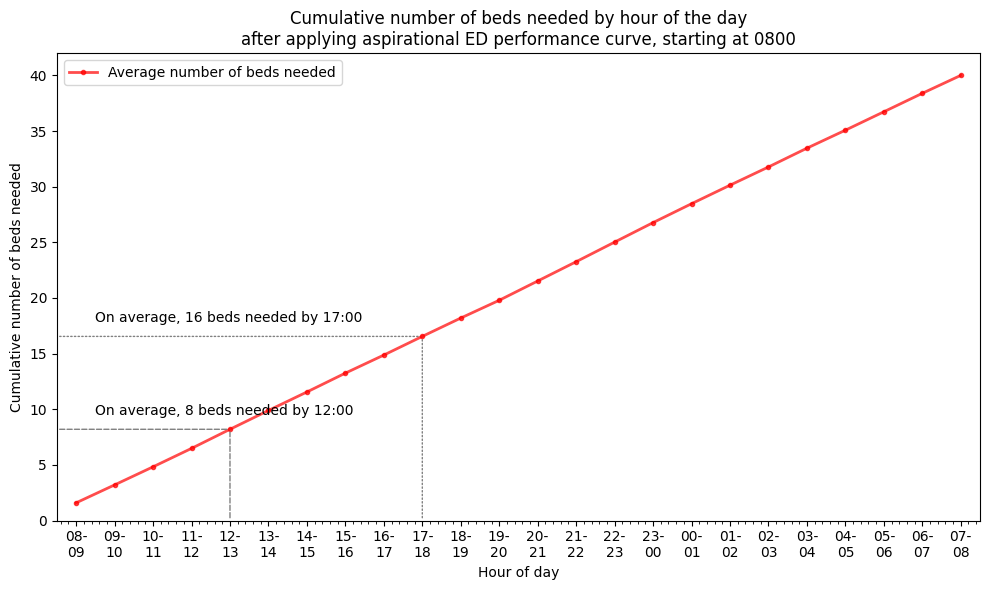

Calculating time-varying arrival rates for data provided, which spans 306 unique dates


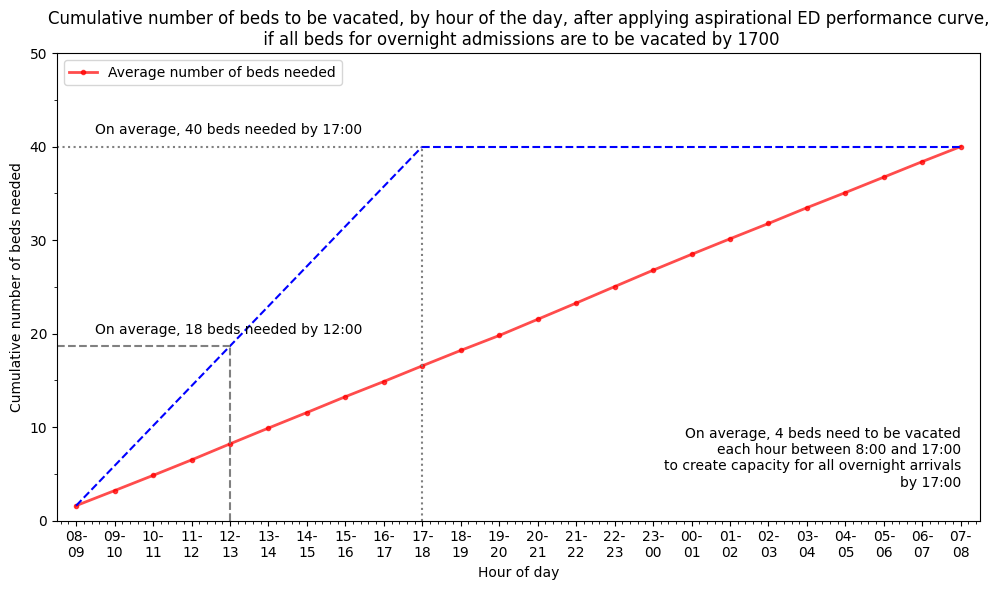

Calculating time-varying arrival rates for data provided, which spans 306 unique dates


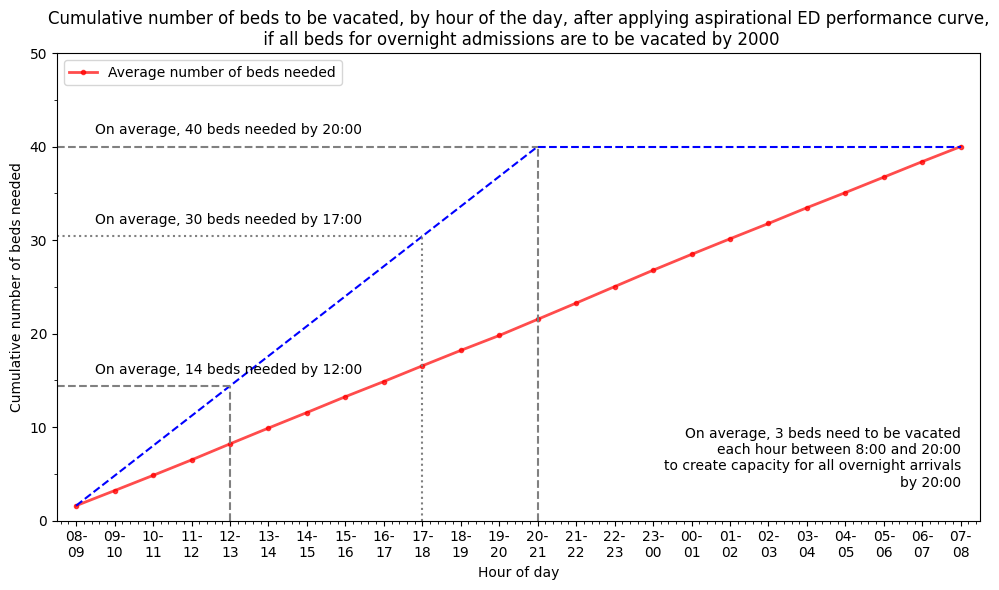

In [99]:
# title = 'Cumulative number of beds needed, by hour of the day after applying aspirational ED performance curve'
# plot_cumulative_arrival_rates(hour_labels, list(poisson_means_sum), title, start_plot_index = 0)

title = 'Cumulative number of beds needed by hour of the day\nafter applying aspirational ED performance curve, starting at 0800'
plot_cumulative_arrival_rates(inpatient_arrivals, title, curve_params=(x1, y1, x2, y2), start_plot_index = 8,  file_prefix = '6_')

start_of_influencable_window = 8
end_of_influencable_window = 17
title = f'Cumulative number of beds to be vacated, by hour of the day, after applying aspirational ED performance curve,\n if all beds for overnight admissions are to be vacated by {end_of_influencable_window}00'
plot_cumulative_arrival_rates(inpatient_arrivals, title, curve_params=(x1, y1, x2, y2), start_plot_index = 8, draw_window = (start_of_influencable_window, end_of_influencable_window), file_prefix = '7_', set_y_lim = 50)

end_of_influencable_window = 20
title = f'Cumulative number of beds to be vacated, by hour of the day, after applying aspirational ED performance curve,\n if all beds for overnight admissions are to be vacated by {end_of_influencable_window}00'
plot_cumulative_arrival_rates(inpatient_arrivals, title, curve_params=(x1, y1, x2, y2), start_plot_index = 8, draw_window = (start_of_influencable_window, end_of_influencable_window), file_prefix = '8_', set_y_lim = 50, hour_lines = [12,17,20])

## Cumulative plot with probabilities

Calculating time-varying arrival rates for data provided, which spans 306 unique dates


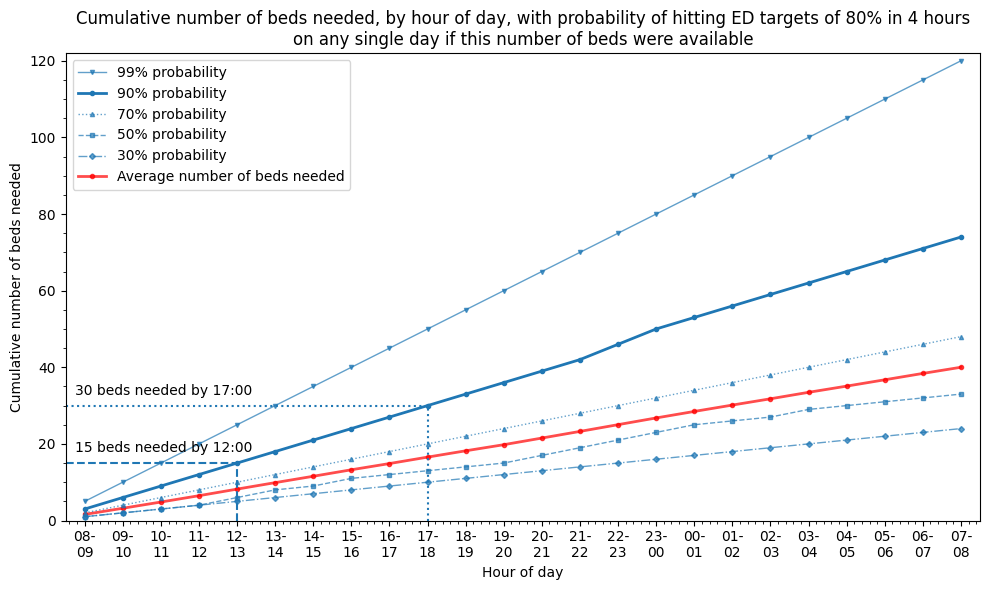

In [101]:
title = f'Cumulative number of beds needed, by hour of day, with probability of hitting ED targets of {int(y1*100)}% in {int(x1)} hours\non any single day if this number of beds were available'
plot_cumulative_arrival_rates(
   inpatient_arrivals,
    title,
    curve_params=(x1, y1, x2, y2),
    lagged_by=None,
    time_interval=60,
    start_plot_index=8,
    draw_window=None,
    x_margin=0.5,
    file_prefix='9_',
    set_y_lim=None,
    hour_lines=[12, 17],
    line_styles={12: '--', 17: ':'},
    annotation_prefix='On average',
    line_colour='red',
    media_file_path=None,
    plot_centiles=True,
    highlight_centile=0.9,
    centiles=[0.3, 0.5, 0.7, 0.9, 0.99],
    markers=['D', 's', '^', 'o', 'v'],
    line_styles_centiles=['-.', '--', ':', '-', '-'],
    bed_type_spec=''

)

## Plot by specialty

Calculating time-varying arrival rates for data provided, which spans 306 unique dates


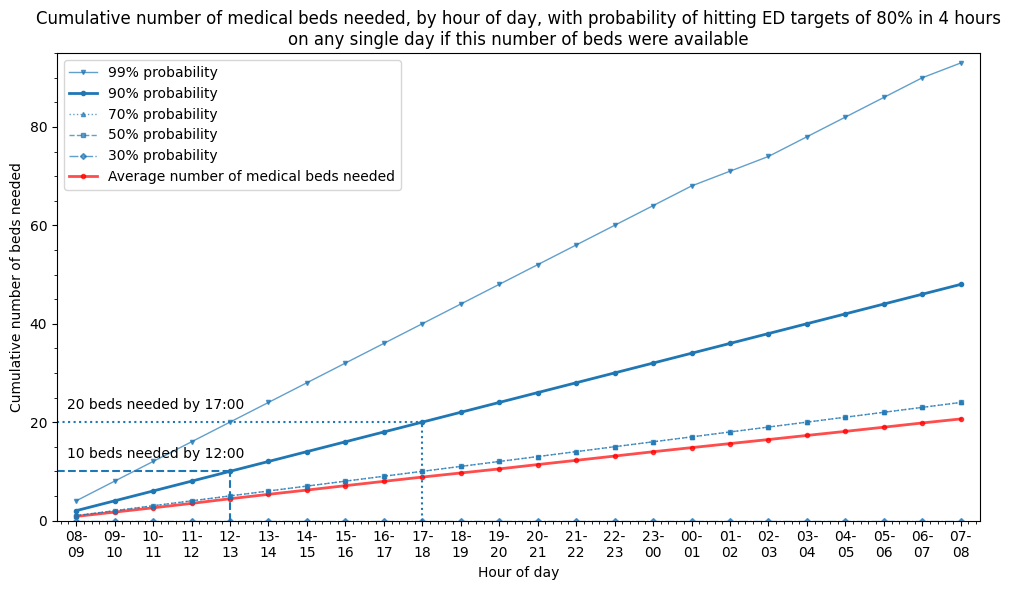

Calculating time-varying arrival rates for data provided, which spans 306 unique dates


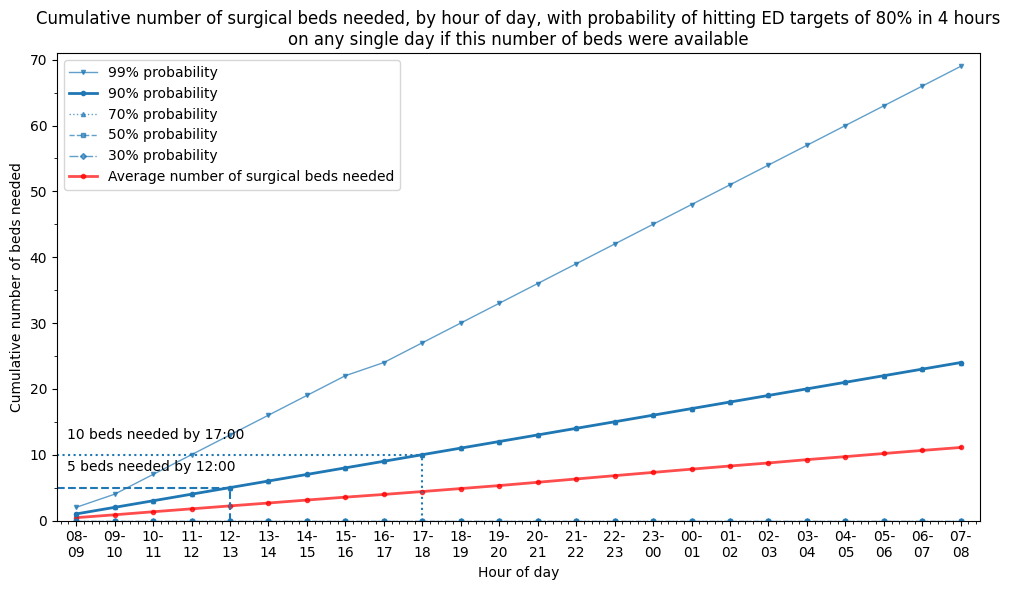

Calculating time-varying arrival rates for data provided, which spans 305 unique dates


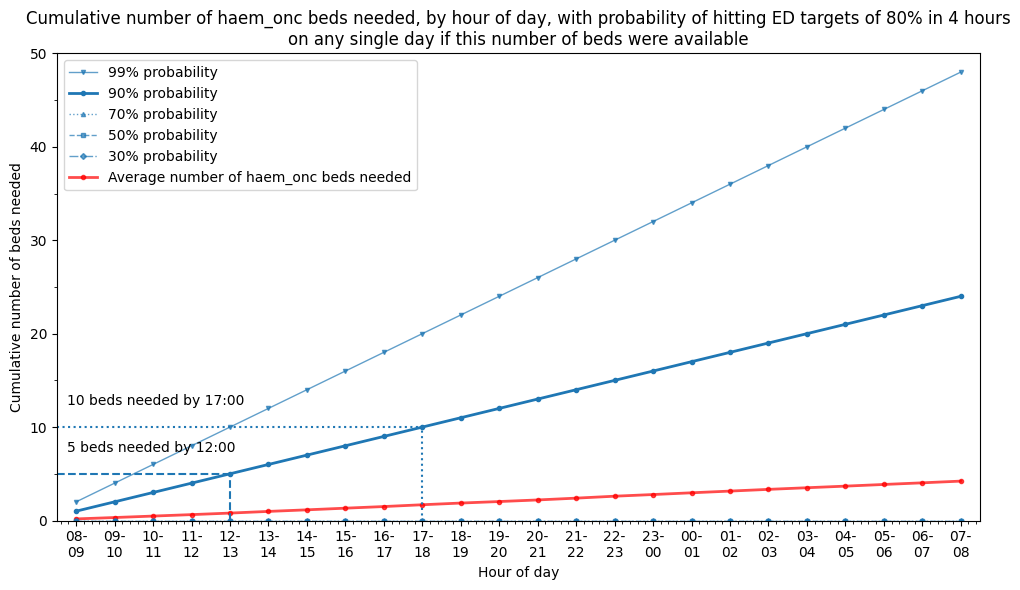

Calculating time-varying arrival rates for data provided, which spans 302 unique dates


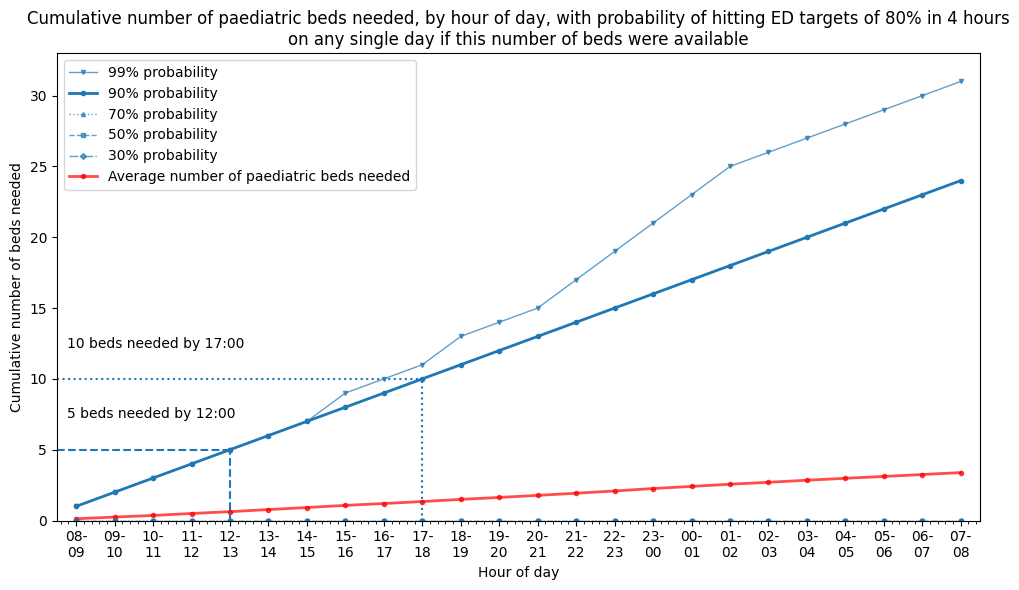

In [102]:
for _spec in ['medical', 'surgical', 'haem/onc', 'paediatric']:
    inpatient_arrivals_spec = inpatient_arrivals[(~inpatient_arrivals.specialty.isnull()) & (inpatient_arrivals.specialty == _spec)]
    __spec = _spec.replace('/', '_')
    
    title = f'Cumulative number of {__spec} beds needed, by hour of day, with probability of hitting ED targets of {int(y1*100)}% in {int(x1)} hours\non any single day if this number of beds were available'

    plot_cumulative_arrival_rates(
    inpatient_arrivals_spec,
        title,
        curve_params=(x1, y1, x2, y2),
        lagged_by=None,
        time_interval=60,
        start_plot_index=8,
        draw_window=None,
        x_margin=0.5,
        file_prefix='A_',
        set_y_lim=None,
        hour_lines=[12, 17],
        line_styles={12: '--', 17: ':'},
        annotation_prefix='On average',
        line_colour='red',
        media_file_path=None,
        plot_centiles=True,
        highlight_centile=0.9,
        centiles=[0.3, 0.5, 0.7, 0.9, 0.99],
        markers=['D', 's', '^', 'o', 'v'],
        line_styles_centiles=['-.', '--', ':', '-', '-'],
        bed_type_spec=__spec

    )
    


### Including influencable window

NOTE - currently you can only draw window or plot centiles